# Necessary Path Settings

In [1]:
import sys
import os

# Add the project root to sys.path
sys.path.append(os.path.abspath(".."))

### Function Monitor

In [2]:
import time
import tracemalloc

def timed_memory_profile(func, *args, **kwargs):
    tracemalloc.start()
    start_time = time.perf_counter()

    result = func(*args, **kwargs)

    end_time = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"Execution time: {end_time - start_time:.4f} seconds")
    print(f"Current memory usage: {current / 1024:.2f} KB")
    print(f"Peak memory usage: {peak / 1024:.2f} KB")

    return result


### Static constants to load once

In [3]:
from nltk.corpus import stopwords, wordnet as wn
from src.services import (
    extract_top_n_nouns_with_frequency,
    get_sentences_with_target_word
)

STOP_WORDS = set(stopwords.words("english"))
ALL_NOUNS = {lemma.name().lower() for synset in wn.all_synsets(wn.NOUN) for lemma in synset.lemmas()}

## -> Book upload and text convert

### Example 1: Psychology book

In [4]:
with open('../static/uploads/psychology_explained.txt') as f:
    text_content = f.read()

print(len(text_content))

873235


## -> Noun Extraction with frequency

In [5]:
extract_top_n_nouns_with_frequency(text_content, 50, STOP_WORDS, ALL_NOUNS)

{'psychology': 621,
 'people': 338,
 'behavior': 316,
 'memory': 290,
 'theory': 254,
 'approach': 218,
 'personality': 215,
 'world': 211,
 'freud': 186,
 'intelligence': 185,
 'life': 183,
 'child': 183,
 'therapy': 178,
 'time': 173,
 'university': 171,
 'study': 165,
 'mind': 160,
 'research': 154,
 'development': 149,
 'work': 143,
 'way': 141,
 'information': 140,
 'see': 137,
 'person': 131,
 'process': 127,
 'context': 127,
 'brain': 124,
 'psychologist': 123,
 'self': 120,
 'idea': 120,
 'us': 117,
 'consciousness': 117,
 'experience': 111,
 'skinner': 108,
 'james': 106,
 'john': 106,
 'learning': 103,
 'environment': 98,
 'feelings': 96,
 'language': 94,
 'part': 93,
 'family': 92,
 'things': 92,
 'experiment': 90,
 'response': 88,
 'years': 86,
 'key': 86,
 'nature': 85,
 'watson': 84,
 'perception': 83}

## -> Sentence Extraction with target word

In [16]:
# target word
target_word = 'world'

sentences = get_sentences_with_target_word(text_content, target_word, 400)

In [17]:
len(sentences)

207

In [18]:
sentences[98]

'once we understand this we can let go of the idea of just world and think more rationally about negative experiences'

## -> Similarity Matrix Generation

In [19]:
import torch
from transformers import BertModel, BertTokenizer
from src.models import DisambModel 

# Load model & tokenizer
bert_model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DisambModel(bert_model, bert_tokenizer, device)


In [20]:
from src.services import compute_cosine_similarity_matrix

sim_matrix, _ = compute_cosine_similarity_matrix(
    sentences=sentences,
    target_word=target_word,
    model=model
)

In [21]:
sim_matrix.shape

torch.Size([207, 207])

## -> Finding Optimal number of clusters from similarity matrix (by using elbow method)

In [22]:
from src.services import suggest_num_clusters_with_data

optimal_k, k_range, wcss = suggest_num_clusters_with_data(sim_matrix)

print("Optimal cluster count in range [1, 10]: ", optimal_k)

Optimal cluster count in range [1, 10]:  2


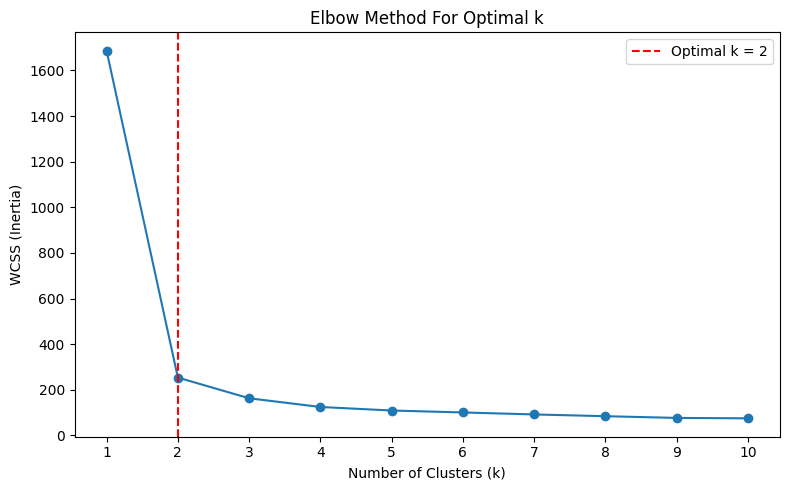

In [23]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)

# Annotate the optimal k
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
from sklearn.cluster import KMeans
import torch
import numpy as np
from typing import List, Dict

# 1. Convert similarity matrix to embeddings using MDS (or use sentence embeddings directly)
from sklearn.manifold import MDS

# Convert similarity to distance for MDS
distance_matrix = 1 - sim_matrix.cpu().numpy()
mds = MDS(n_components=50, dissimilarity='precomputed', random_state=42)
embedding_matrix = mds.fit_transform(distance_matrix)  # shape: [num_sentences, 50]

# 2. Clustering with optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(embedding_matrix)

# 3. Group sentences by cluster
from collections import defaultdict


clustered_sentences: Dict[int, List[str]] = defaultdict(list)
for i, label in enumerate(labels):
    clustered_sentences[label].append(sentences[i])


# 4. Get contextual BERT embeddings for the target noun in each sentence
sentence_embeddings = []
for sent in sentences:
    try:
        emb = model.forward(sent, target_word)
        sentence_embeddings.append(emb.cpu())
    except ValueError:
        sentence_embeddings.append(torch.zeros(768))

sentence_embeddings = torch.stack(sentence_embeddings)  # ✅ make it a tensor


# 5. Compute cluster centroids in BERT embedding space
cluster_centroids: Dict[int, torch.Tensor] = {}
for cluster_id in range(optimal_k):
    idxs = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
    cluster_vectors = sentence_embeddings[idxs]
    cluster_centroids[cluster_id] = cluster_vectors.mean(dim=0)



In [25]:
import torch.nn.functional as F

# Optional: Pick top representative sentence per cluster (closest to centroid)
def get_top_representative_sentences(cluster_id: int, top_n=3) -> List[str]:
    idxs = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
    cluster_vecs = sentence_embeddings[idxs]
    centroid = cluster_centroids[cluster_id].unsqueeze(0)
    sims = F.cosine_similarity(cluster_vecs, centroid)
    top_indices = torch.topk(sims, k=min(top_n, len(sims))).indices.tolist()
    return [sentences[idxs[i]] for i in top_indices]

# Example usage:
# Save representative sentences per cluster to a file
output_file = "summary_clusters.txt"

with open(output_file, "w", encoding="utf-8") as f:
    for cid in range(optimal_k):
        f.write(f"Cluster {cid}:\n")
        for s in get_top_representative_sentences(cid):
            f.write(f"  - {s}\n")
        f.write("\n")  # Add spacing between clusters

print(f"Saved cluster summaries to '{output_file}'")


Saved cluster summaries to 'summary_clusters.txt'
